# Get the names and indexes of the response genes.

In [27]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

import os
import torch

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.models.monet_ae import MonetDense
from spatial.predict import test

import hydra
from hydra.experimental import compose, initialize

os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["OMP_NUM_THREADS"]="1"
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6"

In [28]:
response_genes=np.array(['Ace2', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar', 'Arhgap36',
       'Baiap2', 'Ccnd2', 'Cd24a', 'Cdkn1a', 'Cenpe', 'Chat', 'Coch',
       'Col25a1', 'Cplx3', 'Cpne5', 'Creb3l1', 'Cspg5', 'Cyp19a1',
       'Cyp26a1', 'Dgkk', 'Ebf3', 'Egr2', 'Ermn', 'Esr1', 'Etv1',
       'Fbxw13', 'Fezf1', 'Gbx2', 'Gda', 'Gem', 'Gjc3', 'Greb1',
       'Irs4', 'Isl1', 'Klf4', 'Krt90', 'Lmod1', 'Man1a', 'Mbp', 'Mki67',
       'Mlc1', 'Myh11', 'Ndnf', 'Ndrg1', 'Necab1', 'Nnat', 'Nos1',
       'Npas1', 'Nup62cl', 'Omp', 'Onecut2', 'Opalin', 'Pak3', 'Pcdh11x',
       'Pgr', 'Plin3', 'Pou3f2', 'Rgs2', 'Rgs5', 'Rnd3', 'Scgn',
       'Serpinb1b', 'Sgk1', 'Slc15a3', 'Slc17a6', 'Slc17a8', 'Slco1a4',
       'Sln', 'Sox4', 'Sox6', 'Sox8', 'Sp9', 'Synpr', 'Syt2', 'Syt4',
       'Sytl4', 'Th', 'Tiparp', 'Tmem108', 'Traf4', 'Ttn', 'Ttyh2'])

In [29]:
data = pd.read_csv("../data/raw/merfish.csv")

In [31]:
data = data.drop(["Fos", "Blank_1", "Blank_2", "Blank_3", "Blank_4", "Blank_5"], axis=1)

KeyError: "['Fos', 'Blank_1', 'Blank_2', 'Blank_3', 'Blank_4', 'Blank_5'] not found in axis"

In [32]:
data = data.iloc[:, 9:]

In [33]:
data.shape, data.columns # should start with "Ace2"

((1027848, 155),
 Index(['Ace2', 'Adora2a', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar',
        'Arhgap36', 'Avpr1a', 'Avpr2',
        ...
        'Penk', 'Scg2', 'Sln', 'Sst', 'Tac1', 'Tac2', 'Th', 'Trh', 'Ucn3',
        'Vgf'],
       dtype='object', length=155))

In [34]:
response_indexes = [0,2,3,4,5,6,7,10,19,20,21,22,23,24,25,26,27,28,32,34,35,37,38,39,40,41,42,43,44,52,53,54,55,58,63,64,66,67,69,71,73,74,75,76,77,78,79,80,85,86,87,88,93,94,96,97,99,102,103,104,106,110,112,113,114,116,118,119,120,121,122,123,124,125,126,129,130,131,133,134,141,142,147,151]

In [35]:
IGNORANT_RADIUS = 0
AWARE_RADIUS = [5,10,15,20,25,30,35,40,45,50]

In [36]:
data = data.iloc[0:0]  # Keep only the column names, remove all rows


# Load the test losses for spatially ignorant baseline.

In [ ]:
test_loss_rad_dict = {}

for rad in [IGNORANT_RADIUS]:
    with initialize(config_path="../config"):
        # try:
            cfg_from_terminal = compose(config_name="config")
            OmegaConf.update(cfg_from_terminal, "paths.data", "../data")
            OmegaConf.update(cfg_from_terminal, "paths.root", "/nfs/turbo/lsa-regier/scratch/roko")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.observables_dimension", 71)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [512, 512, 512, 512, 512, 512])
            OmegaConf.update(cfg_from_terminal, "model.kwargs.output_dimension", 84)
            OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.kernel_size", 15)
            OmegaConf.update(cfg_from_terminal, "training.logger_name", "table2_FULL_no_celltypes")
            OmegaConf.update(cfg_from_terminal, "training.trainer.strategy", "auto")
            OmegaConf.update(cfg_from_terminal, "datasets.dataset.include_celltypes", False)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.include_skip_connections", True)
            OmegaConf.update(cfg_from_terminal, "radius", rad)
            OmegaConf.update(cfg_from_terminal, "gpus", [2])
            print(cfg_from_terminal.training.filepath)
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
            test_loss_rad_dict[rad] = test_results_BASE[0]['test_loss']
        # except:
        #     try:
        #         OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [256, 256, 256, 256, 256, 256])
        #         print(cfg_from_terminal.training.filepath)
        #         output = test(cfg_from_terminal)
        #         trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
        #         test_loss_rad_dict[rad] = test_results_BASE[0]['test_loss']
        #     except:
        #         print(f"Model with radius of {rad} micrometers doesn't exist :(")

# Load the test losses for spatially aware model.

In [97]:
def calc_r2(truth, predictions):
    SS_res = torch.sum((truth - predictions)**2).item()
    SS_tot = torch.sum((truth - torch.mean(truth))**2).item()
    return 1 - SS_res/SS_tot

In [37]:
with open("0v60.json", "r") as f:
    loss_dict = json.load(f)

In [ ]:
r2_dict = {}
inputs_BASE_responses = inputs_BASE[:, response_indexes]
AWARE_RADIUS = [25]

for rad in AWARE_RADIUS:
    with initialize(config_path="../config"):
        try:
            cfg_from_terminal = compose(config_name="config")
            OmegaConf.update(cfg_from_terminal, "paths.data", "../data")
            OmegaConf.update(cfg_from_terminal, "paths.root", "/nfs/turbo/lsa-regier/scratch/roko")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.observables_dimension", 71)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [512, 512, 512, 512, 512, 512])
            OmegaConf.update(cfg_from_terminal, "model.kwargs.output_dimension", 84)
            OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.kernel_size", 15)
            OmegaConf.update(cfg_from_terminal, "training.logger_name", "table2_FULL_no_celltypes")
            OmegaConf.update(cfg_from_terminal, "training.trainer.strategy", "auto")
            OmegaConf.update(cfg_from_terminal, "datasets.dataset.include_celltypes", False)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.include_skip_connections", True)
            OmegaConf.update(cfg_from_terminal, "radius", rad)
            OmegaConf.update(cfg_from_terminal, "gpus", [2])
            print(cfg_from_terminal.training.filepath)
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs_SPATIAL, gene_expressions_SPATIAL, celltypes, test_results_SPATIAL = output
            test_loss_rad_dict[rad] = test_results_SPATIAL[0]['test_loss']
        except:
            try:
                OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [256, 256, 256, 256, 256, 256])
                print(cfg_from_terminal.training.filepath)
                output = test(cfg_from_terminal)
                trainer, l1_losses, inputs_SPATIAL, gene_expressions_SPATIAL, celltypes, test_results_SPATIAL = output
                test_loss_rad_dict[rad] = test_results_SPATIAL[0]['test_loss']
            except:
                print(f"Model with radius of {rad} micrometers doesn't exist :(")
    loss_dict[rad] = {}
    r2_dict[rad] = {}
    for i, gene in enumerate(response_genes):
        inputs_SPATIAL_responses = inputs_SPATIAL[:, response_indexes]
        current_gene = data.columns[response_indexes[i]]
        r2_dict[rad][current_gene] = {"base": calc_r2(inputs_BASE_responses[:, i], gene_expressions_BASE[:, i]), "spatial": calc_r2(inputs_SPATIAL_responses[:, i], gene_expressions_SPATIAL[:, i])}
        loss_dict[rad][current_gene] = {"base": torch.mean( (inputs_BASE_responses[:, i] - gene_expressions_BASE[:, i]) ** 2 ).item(), "spatial": torch.mean( (inputs_SPATIAL_responses[:, i] - gene_expressions_SPATIAL[:, i]) ** 2 ).item()}
        loss_dict[rad][current_gene]["diff"] = loss_dict[rad][current_gene]["spatial"] - loss_dict[rad][current_gene]["base"]
        loss_dict[rad][current_gene]["percent_diff"] = (loss_dict[rad][current_gene]["diff"]/loss_dict[rad][current_gene]["base"]) * 100.0

In [38]:
genes = [data.columns[i] for i in response_indexes]

# Get the losses for each response gene in both cases.

In [39]:
loss_dict

{'5': {'Ace2': {'base': 0.14470702409744263,
   'spatial': 0.14529971778392792,
   'diff': 0.0005926936864852905,
   'percent_diff': 0.4095818362529404},
  'Aldh1l1': {'base': 0.6029497981071472,
   'spatial': 0.6033490896224976,
   'diff': 0.0003992915153503418,
   'percent_diff': 0.06622301170078271},
  'Amigo2': {'base': 0.41306960582733154,
   'spatial': 0.41165590286254883,
   'diff': -0.0014137029647827148,
   'percent_diff': -0.34224327930185716},
  'Ano3': {'base': 0.19442394375801086,
   'spatial': 0.1938006579875946,
   'diff': -0.0006232857704162598,
   'percent_diff': -0.32058076714667944},
  'Aqp4': {'base': 0.7678506374359131,
   'spatial': 0.7667004466056824,
   'diff': -0.0011501908302307129,
   'percent_diff': -0.1497935632470854},
  'Ar': {'base': 0.5081300139427185,
   'spatial': 0.5012067556381226,
   'diff': -0.006923258304595947,
   'percent_diff': -1.3624974149581344},
  'Arhgap36': {'base': 0.541377067565918,
   'spatial': 0.5351763367652893,
   'diff': -0.00620

In [40]:
with open("0v60.json", "w") as file:
    json.dump(loss_dict, file)

In [16]:
# r2_dict

In [17]:
with open("r2_0v60.json", "w") as file:
    json.dump(r2_dict, file)

# Plot the results.

In [41]:
import matplotlib.pyplot as plt

In [42]:
loss_dict = loss_dict['25']

In [43]:
percent_differences = [-loss_dict[x]["percent_diff"] for x in loss_dict]

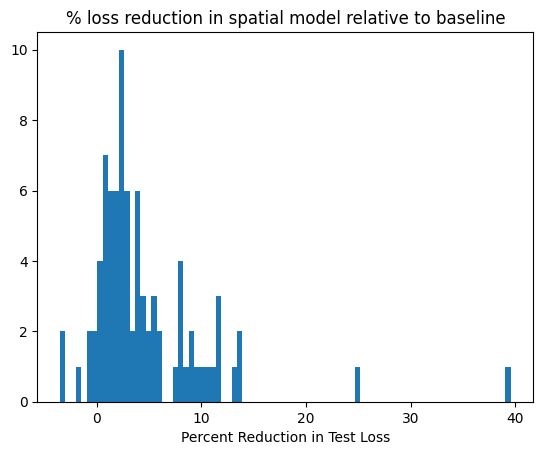

In [44]:
plt.hist(percent_differences, bins=len(loss_dict))
plt.title("% loss reduction in spatial model relative to baseline")
plt.xlabel("Percent Reduction in Test Loss")
plt.show()

# Identify the genes.

In [45]:
loss_dict_sorted = dict(sorted(loss_dict.items(), key=lambda item: item[1]["percent_diff"]))

In [46]:
loss_dict_sorted

{'Nnat': {'base': 0.01004598755389452,
  'spatial': 0.006069127004593611,
  'diff': -0.003976860549300909,
  'percent_diff': -39.586556602483576},
 'Mbp': {'base': 0.05439237877726555,
  'spatial': 0.04089765623211861,
  'diff': -0.013494722545146942,
  'percent_diff': -24.809951041867926},
 'Ebf3': {'base': 0.16109047830104828,
  'spatial': 0.13900195062160492,
  'diff': -0.02208852767944336,
  'percent_diff': -13.711876649943264},
 'Sln': {'base': 0.05354680120944977,
  'spatial': 0.04632866755127907,
  'diff': -0.0072181336581707,
  'percent_diff': -13.48004641759416},
 'Ermn': {'base': 0.7739373445510864,
  'spatial': 0.6704298853874207,
  'diff': -0.10350745916366577,
  'percent_diff': -13.374139378647518},
 'Cd24a': {'base': 0.49862006306648254,
  'spatial': 0.44017210602760315,
  'diff': -0.058447957038879395,
  'percent_diff': -11.721942490526368},
 'Greb1': {'base': 0.2096237987279892,
  'spatial': 0.18519610166549683,
  'diff': -0.02442769706249237,
  'percent_diff': -11.6531

# Annotated Plot

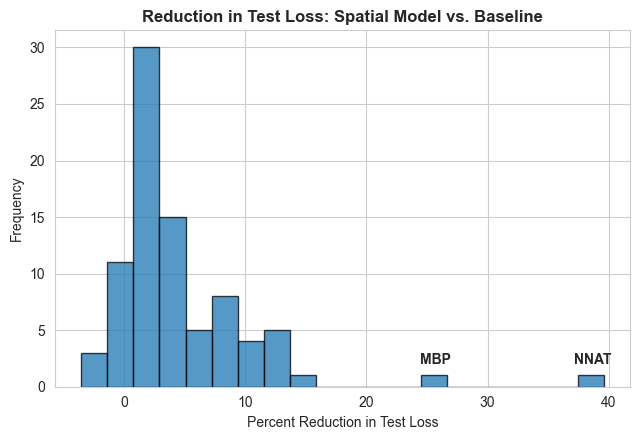

In [47]:
import seaborn as sns

# Set ICML-style aesthetics
sns.set_style("whitegrid")
plt.figure(figsize=(6.5, 4.5))  # Adjust aspect ratio for ICML formatting

# Create Histogram
bins = 20
plt.hist(percent_differences, bins=bins, edgecolor='black', alpha=0.75)

# Titles & Labels
plt.title("Reduction in Test Loss: Spatial Model vs. Baseline", fontsize=12, fontweight='bold')
plt.xlabel("Percent Reduction in Test Loss", fontsize=10)
plt.ylabel("Frequency", fontsize=10)

# Improved Annotations with Arrows
plt.annotate("NNAT", xy=(36.1, 5), xytext=(37.1, 2),
             arrowprops=dict(facecolor='black', arrowstyle="->", lw=1),
             fontsize=10, fontweight='bold')

plt.annotate("MBP", xy=(24.8099, 4), xytext=(24.4, 2),
             arrowprops=dict(facecolor='black', arrowstyle="->", lw=1),
             fontsize=10, fontweight='bold')

# Adjust Layout & Save
plt.tight_layout()
plt.savefig("0VSpatial.png", dpi=600, bbox_inches='tight')
plt.show()

# Heatmap

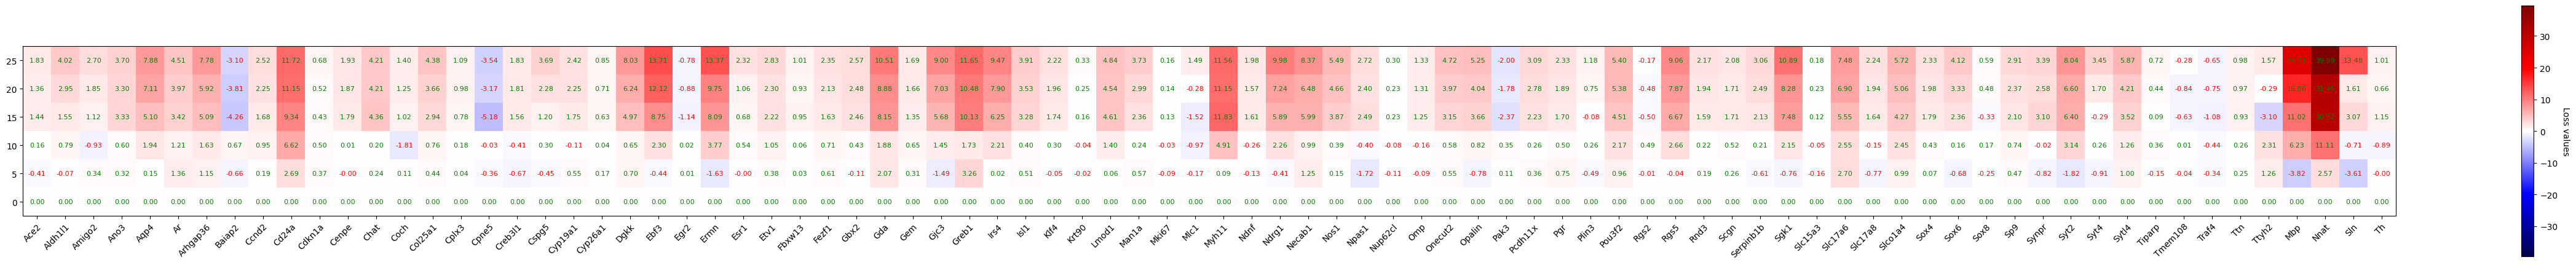

In [52]:
import numpy as np
import matplotlib.pyplot as plt

with open("0v60.json", "r") as file:
    loss_dict = json.load(file)

radius_values = list(range(25, -1, -5))
genes = [data.columns[i] for i in response_indexes]

loss_array = np.array([
    [-loss_dict[str(rad)][gene]["percent_diff"] if rad != 0 else 0 for rad in radius_values] for gene in genes
]).T

# Set the figure size based on the dimensions of your data
cell_width = 0.5
cell_height = 2.5
fig, ax = plt.subplots(figsize=(cell_width*len(genes), cell_height*len(radius_values)))

im = ax.imshow(loss_array, cmap='seismic', vmin=-np.max(np.abs(loss_array)), vmax=np.max(np.abs(loss_array)))

# Add a colorbar for reference
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.005)
cbar.ax.set_ylabel("Loss values", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(genes)))
ax.set_xticklabels(genes)
ax.set_yticks(np.arange(len(radius_values)))
ax.set_yticklabels(list(radius_values))


# Adjust font size
ax.tick_params(axis='both', which='major', labelsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color based on cell value and format the number to 2 decimal places
for i in range(len(radius_values)):
    for j in range(len(genes)):
        if loss_array[i, j] < 0:  # If value is negative, use white text
            text_color = 'red'
        else:  # Otherwise, use black text
            text_color = 'green'
        text = ax.text(j, i, f"{loss_array[i, j]:.2f}",
                       ha="center", va="center", color=text_color, fontsize=8)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
fig.tight_layout()
plt.savefig("spatial_horizontal.png", dpi=600)
plt.show()

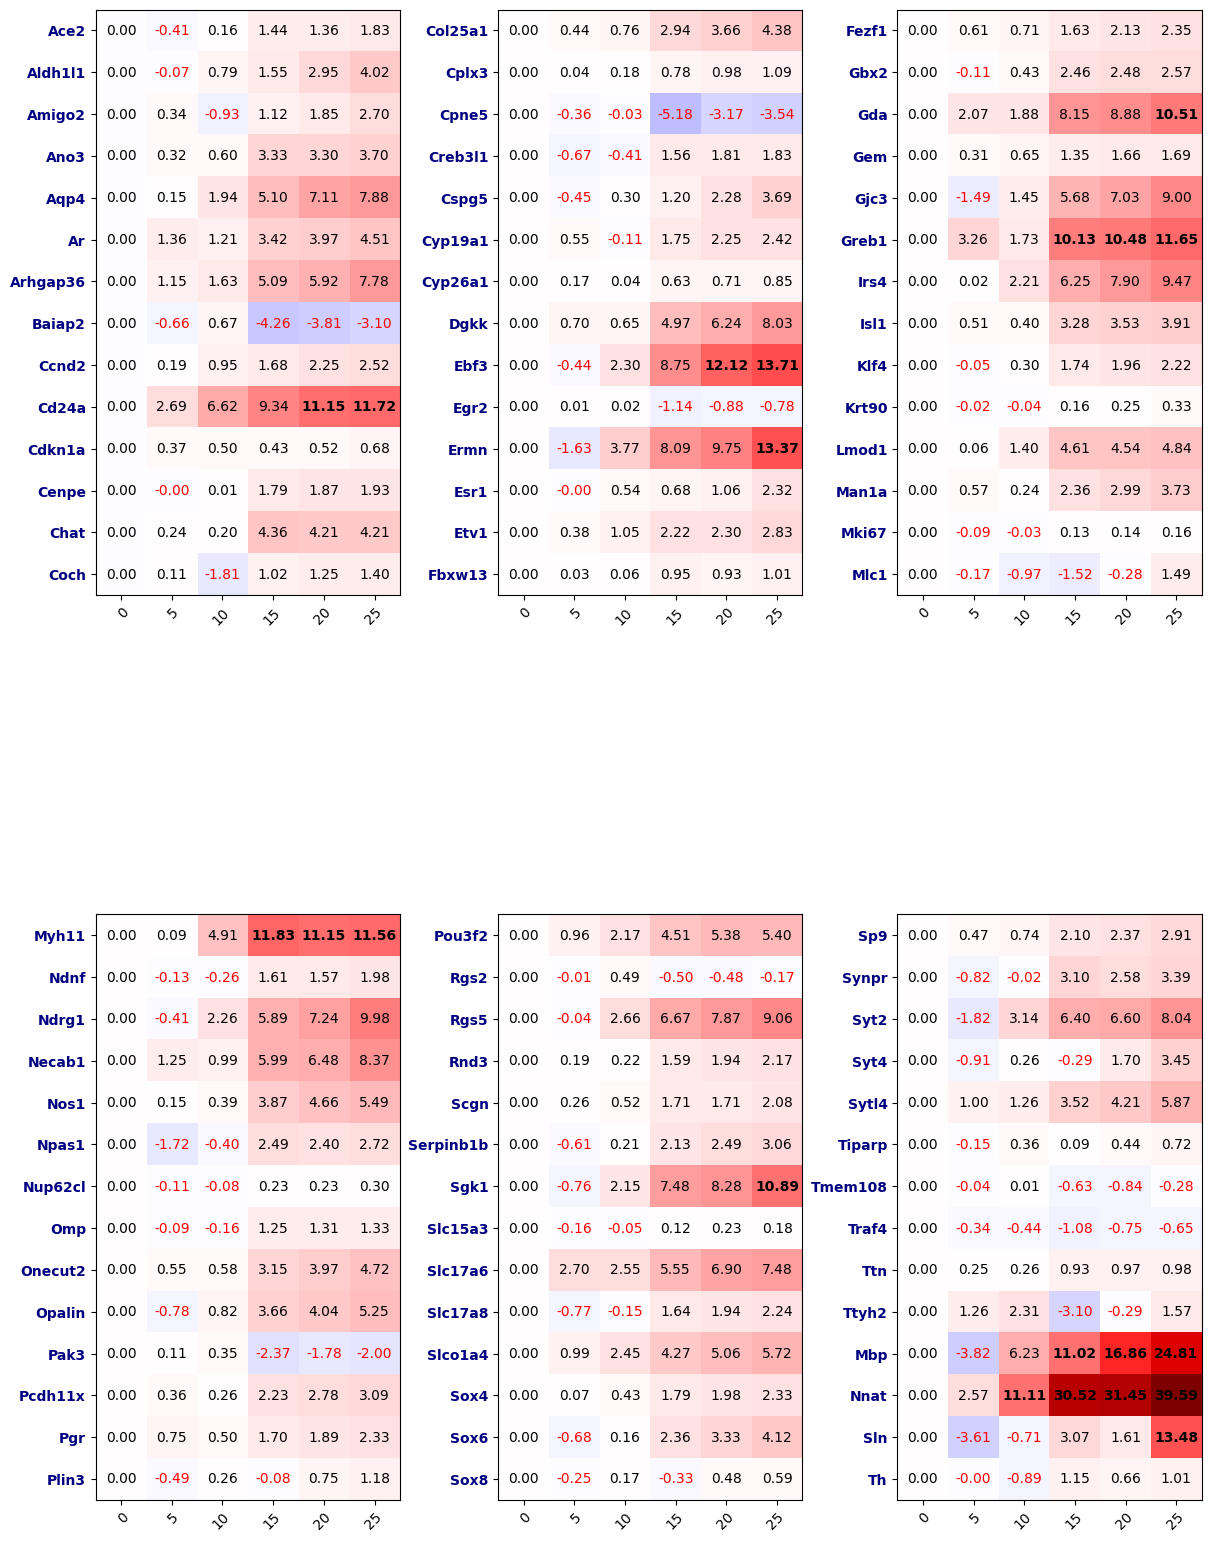

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

plt.style.use('default')

with open("0v60.json", "r") as file:
    loss_dict = json.load(file)

# (Assuming these variables are defined elsewhere in your code)
# radius_values, genes, data, response_indexes

fig, axes = plt.subplots(2, 3, figsize=(12,18))

quarter = 0

full_loss_array = np.array([
    [-loss_dict[str(rad)][gene]["percent_diff"] if rad != 0 else 0 
     for rad in radius_values] 
    for gene in genes
]).T

for ax in axes.ravel():
    
    quarter += 1
    radius_values = list(range(0, 26, 5))
    n = len(response_indexes)
    genes = [data.columns[response_indexes[i]] 
             for i in range(n * (quarter - 1) // 6, n * quarter // 6)]
    
    loss_array = np.array([
        [-loss_dict[str(rad)][gene]["percent_diff"] if rad != 0 else 0 
         for rad in radius_values] 
        for gene in genes
    ])
    
    im = ax.imshow(loss_array, cmap='seismic', 
                   vmin=-np.max(np.abs(full_loss_array)), 
                   vmax=np.max(np.abs(full_loss_array)))
    
    # Increase the width of each cell by adjusting the aspect ratio.
    # A value less than 1 (e.g. 0.825) makes cells wider horizontally.
    ax.set_aspect(0.825)

    ax.set_xticks(np.arange(len(radius_values)))
    ax.set_xticklabels(list(radius_values))

    # Here we set the gene names (y-axis labels) with a custom font dict.
    gene_font = {'fontsize': 10, 'fontweight': 'bold', 'color': 'navy'}
    ax.set_yticks(np.arange(len(genes)))
    ax.set_yticklabels(genes, fontdict=gene_font)

    # Adjust tick font sizes for both axes
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Dynamically adjust text color and font weight based on cell value
    for i in range(len(genes)):
        for j in range(len(radius_values)):
            text_color = 'red' if loss_array[i, j] < 0 else 'black'
            # Make text bold if the loss is greater than 10 (adjust the condition as needed)
            fontweight = 'bold' if loss_array[i, j] > 10 else 'normal'
            ax.text(j, i, f"{loss_array[i, j]:.2f}",
                    ha="center", va="center", color=text_color,
                    fontsize=10, fontweight=fontweight)

fig.tight_layout()
plt.savefig("spatial_vertical_full.png", dpi=600)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("0v60.json", "r") as file:
    loss_dict = json.load(file)

radius_values = list(range(0, 26, 5))
genes = [data.columns[i] for i in response_indexes]

loss_array = np.array([
    [-loss_dict[str(rad)][gene]["percent_diff"] if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# regenerate the loss array with gene filter
THRESHOLD_ABS = 20
THRESHOLD_MIN = 0
genes = [genes[i] for i in range(len(genes)) if ( (sum([np.abs(x) for x in loss_array[i]]) > THRESHOLD_ABS) or sum(loss_array[i]) < THRESHOLD_MIN )]
loss_array = np.array([
    [-loss_dict[str(rad)][gene]["percent_diff"] if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# Set the figure size based on the dimensions of your data
cell_width = 2.5
cell_height = 0.5
fig, ax = plt.subplots(figsize=(cell_width*len(radius_values), cell_height*len(genes)))

im = ax.imshow(loss_array, cmap='seismic', vmin=-np.max(np.abs(loss_array)), vmax=np.max(np.abs(loss_array)))

# Increase the width of each cell by adjusting the aspect ratio.
# A value less than 1 (e.g. 0.825) makes cells wider horizontally.
ax.set_aspect(0.825)

# Add a colorbar with an adjusted fraction to make it thinner.
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
cbar.ax.set_ylabel("% Loss Reduction", fontsize=20, rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(radius_values)))
ax.set_xticklabels(list(radius_values))

# Here we set the gene names (y-axis labels) with a custom font dict.
gene_font = {'fontsize': 10, 'fontweight': 'bold', 'color': 'navy'}
ax.set_yticks(np.arange(len(genes)))
ax.set_yticklabels(genes, fontdict=gene_font)

# Adjust tick font sizes for both axes
ax.tick_params(axis='both', which='major', labelsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color and font weight based on cell value
for i in range(len(genes)):
    for j in range(len(radius_values)):
        text_color = 'red' if loss_array[i, j] < 0 else 'black'
        # Make text bold if the loss is greater than 10 (adjust the condition as needed)
        fontweight = 'bold' if loss_array[i, j] > 10 else 'normal'
        ax.text(j, i, f"{loss_array[i, j]:.2f}",
                ha="center", va="center", color=text_color,
                fontsize=10, fontweight=fontweight)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
# fig.tight_layout()
plt.savefig("spatial_vertical.png", dpi=600)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("r2_0v60.json", "r") as file:
    r2_dict = json.load(file)

fig, axes = plt.subplots(2, 2, figsize=(12,18))

quarter = 0

radius_values = list(range(0, 26, 5))
genes = [data.columns[i] for i in response_indexes]

full_r2_array = np.array([
    [r2_dict[str(rad)][gene]["spatial"] if rad != 0 else r2_dict["5"][gene]["base"] for rad in radius_values] for gene in genes
])

for ax in axes.ravel():
    
    quarter += 1
    n = len(response_indexes)
    genes = [data.columns[response_indexes[i]] for i in range(n * (quarter - 1) // 4, n * quarter // 4)]
    
    r2_array = np.array([
        [r2_dict[str(rad)][gene]["spatial"] if rad != 0 else r2_dict["5"][gene]["base"] for rad in radius_values] for gene in genes
    ])

    # Set the figure size based on the dimensions of your data
    cell_width = 2.5
    cell_height = 0.5
    
    im = ax.imshow(r2_array, cmap='coolwarm', vmin=0, vmax=1)
    
    # Add a colorbar for reference with adjusted fraction to make it thinner
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
    cbar.ax.set_ylabel(r"$R^2$", fontsize=20, rotation=-90, va="bottom")
    
    ax.set_xticks(np.arange(len(radius_values)))
    ax.set_xticklabels(list(radius_values))
    ax.set_yticks(np.arange(len(genes)))
    ax.set_yticklabels(genes)
    
    # Adjust font size
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Dynamically adjust text color based on cell value and format the number to 2 decimal places
    for i in range(len(genes)):
        for j in range(len(radius_values)):
            if r2_array[i, j] < r2_array[i, 0]:  # If value is negative, use white text
                text_color = 'red'
            else:  # Otherwise, use black text
                text_color = 'white'
            text = ax.text(j, i, f"{r2_array[i, j]:.2f}",
                           ha="center", va="center", color=text_color, fontsize=10)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
fig.tight_layout()
plt.savefig("spatial_vertical_r2.png", dpi=600)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("r2_0v60.json", "r") as file:
    r2_dict = json.load(file)

radius_values = list(range(0, 26, 5))
genes = [data.columns[i] for i in response_indexes]

r2_array = np.array([
    [r2_dict[str(rad)][gene]["spatial"] if rad != 0 else r2_dict["5"][gene]["base"] for rad in radius_values] for gene in genes
])

# Set the figure size based on the dimensions of your data
cell_width = 2.5
cell_height = 0.5
fig, ax = plt.subplots(figsize=(cell_width*len(radius_values), cell_height*len(genes)))

im = ax.imshow(r2_array, vmin=0, vmax=1, cmap="coolwarm")
# im = ax.imshow(r2_array, vmin=0, vmax=1, cmap="PiYG")

# Add a colorbar for reference with adjusted fraction to make it thinner
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
cbar.ax.set_ylabel(r"$R^2$", fontsize=20, rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(radius_values)))
ax.set_xticklabels(list(radius_values))
ax.set_yticks(np.arange(len(genes)))
ax.set_yticklabels(genes)

# Adjust font size
ax.tick_params(axis='both', which='major', labelsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color based on cell value and format the number to 2 decimal places
for i in range(len(genes)):
    for j in range(len(radius_values)):
        if r2_array[i, j] < r2_array[i, 0]:  # If value is negative, use white text
            text_color = 'red'
        else:  # Otherwise, use black text
            text_color = 'white'
        text = ax.text(j, i, f"{r2_array[i, j]:.2f}",
                       ha="center", va="center", color=text_color, fontsize=10)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
# fig.tight_layout()
plt.savefig("spatial_vertical_r2.png", dpi=600)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("0v60.json", "r") as file:
    loss_dict = json.load(file)

radius_values = list(range(0, 26, 5))
genes = [data.columns[i] for i in response_indexes]

loss_array = np.array([
    [- (loss_dict[str(rad)][gene]["spatial"] - loss_dict[str(rad)][gene]["base"]) if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# regenerate the loss array with gene filter
THRESHOLD_ABS = 0.03
THRESHOLD_MIN = 0
genes = [genes[i] for i in range(len(genes)) if ( (sum([np.abs(x) for x in loss_array[i]]) > THRESHOLD_ABS) or sum(loss_array[i]) < THRESHOLD_MIN )]
loss_array = np.array([
    [- (loss_dict[str(rad)][gene]["spatial"] - loss_dict[str(rad)][gene]["base"]) if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# Set the figure size based on the dimensions of your data
cell_width = 2.5
cell_height = 0.5
fig, ax = plt.subplots(figsize=(cell_width*len(radius_values), cell_height*len(genes)))

im = ax.imshow(loss_array, cmap='seismic', vmin=-np.max(np.abs(loss_array)), vmax=np.max(np.abs(loss_array)))

# Add a colorbar for reference with adjusted fraction to make it thinner
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
cbar.ax.set_ylabel("% Loss Reduction", fontsize=20, rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(radius_values)))
ax.set_xticklabels(list(radius_values))
ax.set_yticks(np.arange(len(genes)))
ax.set_yticklabels(genes)

# Adjust font size
ax.tick_params(axis='both', which='major', labelsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color based on cell value and format the number to 2 decimal places
for i in range(len(genes)):
    for j in range(len(radius_values)):
        if loss_array[i, j] < 0:  # If value is negative, use white text
            text_color = 'red'
        else:  # Otherwise, use black text
            text_color = 'green'
        text = ax.text(j, i, f"{loss_array[i, j]:.2f}",
                       ha="center", va="center", color=text_color, fontsize=10)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
# fig.tight_layout()
plt.savefig("spatial_vertical_LRT.png", dpi=600)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("0v60.json", "r") as file:
    loss_dict = json.load(file)

radius_values = list(range(0, 26, 5))
genes = [data.columns[i] for i in response_indexes]

loss_array = np.array([
    [- (loss_dict[str(rad)][gene]["spatial"] - loss_dict[str(rad)][gene]["base"]) if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# regenerate the loss array with gene filter
# THRESHOLD_ABS = 0.03
# THRESHOLD_MIN = 0
# genes = [genes[i] for i in range(len(genes)) if ( (sum([np.abs(x) for x in loss_array[i]]) > THRESHOLD_ABS) or sum(loss_array[i]) < THRESHOLD_MIN )]
# loss_array = np.array([
#     [- (loss_dict[str(rad)][gene]["spatial"] - loss_dict[str(rad)][gene]["base"]) if rad != 0 else 0 for rad in radius_values] for gene in genes
# ])

# Set the figure size based on the dimensions of your data
cell_width = 2.5
cell_height = 0.5
fig, ax = plt.subplots(figsize=(cell_width*len(radius_values), cell_height*len(genes)))

im = ax.imshow(loss_array, cmap='seismic', vmin=-np.max(np.abs(loss_array)), vmax=np.max(np.abs(loss_array)))

# Add a colorbar for reference with adjusted fraction to make it thinner
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05)
cbar.ax.set_ylabel(r"$MSE_{r} - MSE_{0}$", fontsize=20, rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(radius_values)))
ax.set_xticklabels(list(radius_values))
ax.set_yticks(np.arange(len(genes)))
ax.set_yticklabels(genes)

# Adjust font size
ax.tick_params(axis='both', which='major', labelsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color based on cell value and format the number to 2 decimal places
for i in range(len(genes)):
    for j in range(len(radius_values)):
        if loss_array[i, j] < 0:  # If value is negative, use white text
            text_color = 'red'
        else:  # Otherwise, use black text
            text_color = 'green'
        text = ax.text(j, i, f"{loss_array[i, j]:.2f}",
                       ha="center", va="center", color=text_color, fontsize=10)

# ax.set_title("Predictions Across $r$ Values", fontsize=25)
# fig.tight_layout()
plt.savefig("spatial_vertical_LRT_full.png", dpi=600)
plt.show()

In [ ]:
# LRT on real data.
import numpy as np
import scipy.stats as stats
print(len(response_genes), len(response_indexes))

N = inputs_BASE_responses.shape[0]
for index, gene in enumerate(genes):
    # get gene index
    gene_index = index
    # get gene sample variance
    sample_var = inputs_BASE_responses[:, gene_index].var(axis=0)
    sample_var = torch.mean((inputs_BASE_responses[:, gene_index] - gene_expressions_BASE[:, gene_index]) ** 2)
    print(sample_var)
    # Define the mean and standard deviation for the Gaussian distribution
    mean = (1 / (2 * sample_var)) * (gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]) ** 2
    std_dev = ((1 / sample_var) * (gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]) ** 2) ** 0.5
    assert torch.allclose(2 * mean, std_dev ** 2, atol=1e-6)
    # Get Rejection Criterion
    value_at_05_cdf = stats.norm.ppf(0.05, loc=mean, scale=std_dev)
    # LRT Stat Calculation
    lrt_stat = (2 * inputs_BASE_responses[:, gene_index] * (gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]) + (gene_expressions_SPATIAL[:, gene_index] ** 2 - gene_expressions_BASE[:, gene_index] ** 2))/ (2 * sample_var)
    p_values = stats.norm.cdf(lrt_stat, mean, std_dev)
    print("BONFERRONI CORRECTED P-VALUE: ", (p_values * N < 0.05).mean())
    p_values_corrected = np.minimum(p_values * N, 1.0)  # Adjusted p-values
    print("Fraction of significant sites after Bonferroni: ", (p_values_corrected < 0.05).mean())

    
    # Create a histogram of LRT_stat values
    plt.figure(figsize=(5, 3))
    plt.hist(p_values, bins=50, color='blue', alpha=0.7)
    plt.title(f'Histogram of p-values of LRT_stats for {gene}', fontsize=16)
    plt.xlabel('LRT p-values values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # # Compute site-level p-values
    # site_p_values = stats.norm.cdf(lrt_stat, mean, std_dev)

    # # Clamp p-values to avoid log(0) and ppf(1) issues
    # site_p_values = np.clip(site_p_values, 1e-4, 1 - 1e-4)

    # # Fisher’s p-value combination
    # fisher_stat = -2 * np.sum(np.log(site_p_values))
    # p_value_fisher = 1 - stats.chi2.cdf(fisher_stat, df=2 * len(site_p_values))

    # # Stouffer’s method
    # z_scores = stats.norm.ppf(site_p_values)
    # combined_z = np.sum(z_scores) / np.sqrt(len(site_p_values))
    # p_value_stouffer = stats.norm.cdf(combined_z)

    # print(gene, "FISHER: ", p_value_fisher)
    # print(gene, "STOUFFER: ", p_value_stouffer)

    # Brown's p-value correction

In [ ]:
import numpy as np
import scipy.stats as stats
import torch

for index, gene in enumerate(genes):
    gene_index = index

    # Compute per-gene sample variance
    sample_var = torch.mean((inputs_BASE_responses[:, gene_index] - gene_expressions_BASE[:, gene_index]) ** 2)
    sample_var = inputs_BASE_responses[:, gene_index].var(axis=0)

    # Compute mean and standard deviation
    mean = (1 / (2 * sample_var)) * torch.mean((gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]) ** 2)
    std_dev = torch.sqrt(torch.mean((gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]) ** 2) / (sample_var))
    std_dev = torch.where(std_dev == 0, torch.tensor(1e-8), std_dev)  # Fix zero std_dev

    # Compute LRT statistic
    lrt_stat = (2 * inputs_BASE_responses[:, gene_index] * (gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]) +
        (gene_expressions_SPATIAL[:, gene_index] ** 2 - gene_expressions_BASE[:, gene_index] ** 2)) / (2 * sample_var)


    # Standardize LRT before computing p-values
    z_scores = (lrt_stat - mean) / std_dev
    site_p_values = stats.norm.cdf(z_scores)

    # Clip p-values to avoid log(0) and ppf(0)
    site_p_values = np.clip(site_p_values, 1e-16, 1 - 1e-16)
    print(site_p_values)

    # Fisher’s method
    fisher_stat = -2 * np.sum(np.log(site_p_values))
    p_value_fisher = 1 - stats.chi2.cdf(fisher_stat, df=2 * len(site_p_values))

    # Stouffer’s method
    combined_z = np.sum(stats.norm.ppf(site_p_values)) / np.sqrt(len(site_p_values))
    p_value_stouffer = stats.norm.cdf(combined_z)

    # Print debugging info
    print(f"Fisher: {p_value_fisher}, Stouffer: {p_value_stouffer}")


In [75]:
individual_stats = 2 * inputs_BASE_responses[:, gene_index] * (gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]) + (gene_expressions_SPATIAL[:, gene_index] ** 2 - gene_expressions_BASE[:, gene_index] ** 2)

In [ ]:
gene_expressions_BASE[:, gene_index].mean(), gene_expressions_SPATIAL[:, gene_index].mean(), inputs_BASE_responses[:, gene_index].mean()

In [ ]:
((inputs_BASE_responses[:, gene_index] - gene_expressions_BASE[:, gene_index]) ** 2).mean()

In [ ]:
((2 * inputs_BASE_responses[:, gene_index] * (gene_expressions_BASE[:, gene_index] - gene_expressions_SPATIAL[:, gene_index]) + (gene_expressions_SPATIAL[:, gene_index] ** 2 - gene_expressions_BASE[:, gene_index] ** 2))/ (2 * sample_var)).max()

In [ ]:
sample_var